In [1]:
import numpy
#  QUESTO CODICE CONTIENE MODELLO COMPLETO DI 2 REATTORE METANOLO IN SERIE CON RAFFREDDAMENTO A OLIO IN SERIE (ES. MULTITUBULAR_cubotti)
#  CONTIENE 3 CINETICHE : Vanden Bussche–Froment (VBF) AND Graaf (or-GR) and refitted Graaf (ref-GR)
#  Separazione intermedia eseguita con Aspen HYSYS

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import os
import win32com.client as win32
import thermo

In [2]:
def TubularReactor(z,y,Re,Epsilon,RhoGas,Dp,u,m,Aint,MW,nu,R,DHreact,Cpmix,dTube,U,m_oil,Cpl,Nt,Kinetic,RhoC):

    omega = y[0:6]
    T = y[6]
    TShell = y[7]
    P = y[8]

    # Aux. Calculations

    mi = m*omega                                           # Mass flowrate per tube per component [kg/s tube]
    ni = np.divide(mi,MW)                                  # Molar flowrate per tube per component [kmol/s tube]
    ntot = np.sum(ni)                                       # Molar flowrate per tube [kmol/s tube]
    yi = ni/ntot                                            # Molar fraction

    MWmix = np.sum(np.multiply(yi,MW))                      # Mixture molecular weight

    Pi = P*yi                                               # Partial Pressure
    Ppa = P*1E5                                             # Pressure [Pa]

    Eta = 1                                                 # Efficiency of reaction

#################################################################
    # EOS SRK [MeOH, CO, CO2, H2, H2O, Me]
    Tcs = np.array([513.0, 133.0, 304.0, 33.0, 647.3, 191.0])
    Pcs = np.array([81E5, 35E5, 73.8E5, 13.2E5, 221.2E5, 46E5])
    omegas = np.array([0.559, 0.049, 0.225, -0.22, 0.344, 0.01])
    SRK_MIX = thermo.eos_mix.SRKMIX(T=np.abs(T), P=Ppa, Tcs=Tcs, Pcs=Pcs, omegas=omegas, zs=yi)

    if SRK_MIX.phase == "l":
        fii = SRK_MIX.fugacities_l  # fugacity coefficients for each comp. in mixture [Pa]
    else:
        fii = SRK_MIX.fugacities_g

    fi = fii * 1E-5

##################################################################
# Kinetic Costant and Rate of reaction

    match Kinetic:

        case '1': #VBF do not depend on catalyst density

            kd1 = 6.16e+3 * np.exp(+36696 / R / T)
            kr1 = 2.4e+14 * np.exp(-21999 / R / T)
            k11 = 3453.6
            k12 = 0.499 * np.exp(+17197 / R / T)
            k13 = 6.62e-11 * np.exp(+1.2412e+5 / R / T)

            kd2 = 7.02e+13 * np.exp(-94765 / R / T)
            kr2 = 6.57e+11 * np.exp(-55080 / R / T)
            k21 = 3453.6
            k22 = 0.499 * np.exp(+17197 / R / T)
            k23 = 6.62e-11 * np.exp(+1.2412e+5 / R / T)

            rj = np.array([(kd1*Pi[2]*Pi[3]-kr1*Pi[0]*Pi[4]/Pi[3]**2)/(1+k11*Pi[4]/Pi[3]+k12*Pi[3]**(0.5)+k13*Pi[4])**3 , (kd2 * Pi[2] - kr2 * Pi[1] * Pi[4] / Pi[3]) / (1 + k21 * Pi[4] / Pi[3] + k22 * Pi[3] ** 0.5 + k23 * Pi[4]) ]) /3600

        case '2':                       # or-gr

            kd1 = 7.68e-2 * np.exp(-25800 / R / T)
            kr1 = 3.01e+9 * np.exp(-84500 / R / T)

            kd2 = 6.80e+5 * np.exp(-91200 / R / T)
            kr2 = 6.36e+3 * np.exp(-51500 / R / T)

            kd3 = 1.06e+3 * np.exp(-66200 / R / T)
            kr3 = 4.41e+15 * np.exp(-165000 / R / T)

            KCO = 2.16e-5 * np.exp(46800 / R / T)
            KCO2 = 7.05e-7 * np.exp(61700 / R / T)
            Kads = 6.37e-9 * np.exp(84000 / R / T)

            DEN = (1 + KCO * fi[1] + KCO2 * fi[2] * fi[3] ** 0.5 + Kads * fi[2] * fi[4])

            rj = np.array([(kd1 * fi[2] * fi[3] ** 1.5 - kr1 * fi[0] * fi[4] / fi[3] ** 1.5) / DEN,
                           (kd2 * fi[2] * fi[3] - kr2 * fi[4] * fi[1]) / DEN,
                           (kd3 * fi[2] * fi[3] ** 1.5 - kr3 * fi[0] * fi[3] ** -0.5) / DEN]) * RhoC * (
                         1 - Epsilon) / Epsilon / 1000

        case '3':                        # BIS

            kd1 = 1.42e-2 * np.exp(-30700 / R / T)
            kr1 = 2.95e+4 * np.exp(-28000 / R / T)

            kd2 = 6.53e+10 * np.exp(-134920 / R / T)
            kr2 = 3.26e+3 * np.exp(-33600 / R / T)

            kd3 = 0.184 * np.exp(-30135 / R / T)
            kr3 = 1.44e+17 * np.exp(-190000 / R / T)

            KCO2 = 1.54e-3 * np.exp(14900 / R / T)
            KCO = 8.21e-9 * np.exp(76600 / R / T)
            Kads = 3.82e-9 * np.exp(97400 / R / T)

            DEN = (1 + KCO * fi[1] + KCO2 * fi[2] * fi[3] ** 0.5 + Kads * fi[2] * fi[4])

            rj = np.array([(kd1 * fi[2] * fi[3] ** 1.5 - kr1 * fi[0] * fi[4] / fi[3] ** 1.5) / DEN,
                           (kd2 * fi[2] * fi[3] - kr2 * fi[4] * fi[1]) / DEN,
                           (kd3 * fi[2] * fi[3] ** 1.5 - kr3 * fi[0] * fi[3] ** -0.5) / DEN]) * RhoC * (
                             1 - Epsilon) / Epsilon / 1000

    # Equations
    Reactor1 = Epsilon * Aint / m * MW[0] * np.sum(np.multiply(nu[:, 0], np.multiply(Eta, rj)))
    Reactor2 = Epsilon * Aint / m * MW[1] * np.sum(np.multiply(nu[:, 1], np.multiply(Eta, rj)))
    Reactor3 = Epsilon * Aint / m * MW[2] * np.sum(np.multiply(nu[:, 2], np.multiply(Eta, rj)))
    Reactor4 = Epsilon * Aint / m * MW[3] * np.sum(np.multiply(nu[:, 3], np.multiply(Eta, rj)))
    Reactor5 = Epsilon * Aint / m * MW[4] * np.sum(np.multiply(nu[:, 4], np.multiply(Eta, rj)))
    Reactor6 = Epsilon * Aint / m * MW[5] * np.sum(np.multiply(nu[:, 5], np.multiply(Eta, rj)))
    Reactor7 = (np.pi*dTube*U*(TShell-T)+np.sum(np.multiply(-DHreact,np.multiply(Eta,rj)))*10**3*Aint*Epsilon)/m/Cpmix
    Reactor8 = (U*np.pi*dTube/Cpl/m_oil*(T-TShell)*Nt)
    Reactor9 = (-(1.75+150*(1-Epsilon)/Re)*u**2*RhoGas/Dp*(1-Epsilon)/Epsilon**3)*10**(-5)

    return np.array([Reactor1, Reactor2, Reactor3, Reactor4, Reactor5, Reactor6, Reactor7, Reactor8, Reactor9])


In [3]:
# Components  [MeOH, CO, CO2, H2, H2O, Me]

################################################################################
# Kinetic choice
Kinetic = input('ENTER PREFERRED KINETIC PACKAGE \nAvailable Input: "VBF" = 1 ; "or-GR" = 2 ; "ref-GR" = 3 \nAnswer:   ')

match Kinetic:

    case '1':
        nu = np.array([[1, 0, -1, -3, 1, 0],
            [0, 1, -1, -1, 1, 0]])  # CO2toMeOH ; WGS

    case '2':
        nu = np.array([[1, 0, -1, -3, 1, 0],
            [0, 1, -1, -1, 1, 0],
            [1, -1, 0, -2, 0, 0]])  # CO2toMeOH ; WGS ; COtoMeOH

    case '3':
        nu = np.array([[1, 0, -1, -3, 1, 0],
            [0, 1, -1, -1, 1, 0],
            [1, -1, 0, -2, 0, 0]])  # CO2toMeOH ; WGS ; COtoMeOH

ENTER PREFERRED KINETIC PACKAGE 
Available Input: "VBF" = 1 ; "or-GR" = 2 ; "ref-GR" = 3 
Answer:   1


In [4]:
# Input Data First Reactor


MW = np.array([32.04, 28.01, 44.01, 2.016, 18.01528, 16.04])                  # Molecular Molar weight       [kg/kmol]
Cp = np.array([37, 29, 41, 28, 35, 42])                                       # Specific heat for each component (AVG temperature) [kj/kgK]

# Reactor Design

Nt = 76                                                            # Number of tubes
dTube = 4.496e-2                                                    # Tube diameter [m], 1.5in
L = 5                                                               # Length of the reactor [m]

Epsilon = 0.387                                                     # Void Fraction
RhoC = 1170                                                         # Catalyst density [kg/m3]
Dp = 6e-3                                                           # Catalyst particle diameter [m]

U = 100                                                             # Overall heat transfer coefficient [W/m2K]  # Water mass flow   [kg/s]ml = 30000/3600
#ml = 30000/3600                                                     # Mass Flow Oil [kg/s]
Cpl = 2.15e+3                                                       # j/kgK
TShellin = 210+273.15                                               # Inlet Oil Temperature at first reactor [K]

# Input Streams

M = 1918/3600                                                         # Input Mass Flowrate [kg/s]
omegain = [0.0093, 0.2481, 0.5006, 0.1092, 0.0050, 0.1278]            # Inlet mass composition
RhoGas = 17.5                                                       # Gas density (Average condition) [kg/m3]
DynVis = 1.88e-5                                                    # Dynamic Viscosity (Average condition) [Kg/ms]
Cpmix = 2767.213                                                    # Specific heat capacity [j/kgK]

Tin = 250+273.15                                                    # Inlet Temperature [K]
Pin = 61                                                          # Inlet Pressure [Bar]

# Thermodynamic Data

R = 8.314                                                           # [kj/kmolK]
DG0f = np.array([-161.96, -137.69, -394.359, 0, -228.572, 1])                 # Gibbs energy of formation at 298K [kj/kmol]
DH0f = np.array([-200.66, -110.525, -393.509, 0, -241.818, 1])                # Enthalpy of formation             [kj/mol]

##############################################
# Auxiliary Calculations

Aint = numpy.pi*dTube**2/4                                           # Tube section [m2]

m = M/Nt                                                            # Mass Flowrate per tube [kg/s tube]
VolFlow = m/RhoGas                                                  # Volumetric flow per tube [m3/s]
Visc = DynVis/RhoGas                                                # Kinematic viscosity (Average condition) [m2/s]

u = VolFlow/(Aint*Epsilon)                                          # Gas velocity in the tube [m/s]            (BASSA)
Re = RhoGas*u*dTube/DynVis                                          # Reynolds number []

DGreact = np.sum(np.multiply(nu,DG0f),axis=1).transpose()           # Gibbs free energy of reaction at 298K  [kj/kmol]

DHreact = np.sum(np.multiply(nu,DH0f),axis=1).transpose()*10**3     # Enthalpy of reaction              [kj/kmol]

# Shell side design

d_r = 0.620                                                         # Reactor diameter from draw.io [m]

A_Tube = Aint*Nt                                                    # Tube side area [m2]
ul = 0.3                                                            # Velocity of the coolant [m/s]
A_tot = np.pi*d_r**2/4                                              # Total area of the reactor [m2]
A_shell = A_tot - A_Tube                                            # Shell area [m2]
V_oil = A_shell*ul*1000                                             # Volumetric Flow Oil [l/s]
Rho_Oil = 0.9                                                       # Oil Density [kg/dm3] [kg/l]
m_oil = V_oil * Rho_Oil

##############################################
# Solver First Reactor

zspan = np.array([0,L])
z = np.linspace(0,L,401)
y0 = omegain
y0.extend([Tin, TShellin, Pin])
y0 = np.array(y0)

sol = solve_ivp(TubularReactor, zspan, y0, t_eval=z, args=(Re,Epsilon,RhoGas,Dp,u,m,Aint,MW,nu,R,DHreact,Cpmix,dTube,U,m_oil,Cpl,Nt,Kinetic,RhoC))

omega = np.zeros( (5,401) )
omega = sol.y[0:5]
T = sol.y[6] - 273.15
TShell = sol.y[7] - 273.15
P = sol.y[8]

TShellin2 = TShell[-1] + 273.15

In [5]:
Path = os.path.abspath(r'C:\Users\mbozzini\OneDrive - Politecnico di Milano\Desktop\PhD\Progetti Industriali\Cubetti\Synthesis\Separazione_reattori.hsc')

HyApp = win32.Dispatch('HYSYS.Application')
HyCase = HyApp.SimulationCases.Open(Path)

HyCase.Solver.CanSolve = False

#Stream uscente dal reattore
HyStream = HyCase.Flowsheet.MaterialStreams.Item('6')
HyStream.Pressure.SetValue(P[-1]*10**2)
HyStream.ComponentMassFraction.SetValues([omegain[5], omega[4,-1], 0, 0, omega[2,-1], omega[3,-1], omega[1,-1], 0, omega[0,-1], 0])
HyCase.Solver.CanSolve = True

#Stream Uscente da top separatore
HyStream = HyCase.Flowsheet.MaterialStreams.Item('8')
M2 = HyStream.MassFlow.GetValue("kg/s")                             # Input Mass Flowrate [kg/s]
omegain_c = HyStream.ComponentMassFraction.Values
omegain2 = ([omegain_c[8], omegain_c[6], omegain_c[4], omegain_c[5], omegain_c[1], omegain_c[0]])            # Inlet mass composition
RhoGas2 = 18.5                                                      # Gas density (Average condition) [kg/m3]
DynVis2 = 1.78e-5                                                    # Dynamic Viscosity (Average condition) [Kg/ms]
Cpmix2 = 2810                                                        # Specific heat capacity [j/kgK]

Tin2 = 250+273.15                                                    # Inlet Temperature [K]
Pin2 = 64.8                                                          # Inlet Pressure [Bar]


In [6]:
# Auxiliary calculation second reactor

m2 = M2/Nt                                                            # Mass Flowrate per tube [kg/s tube]
VolFlow2 = m2/RhoGas2                                                  # Volumetric flow per tube [m3/s]
Visc2 = DynVis2/RhoGas2                                                # Kinematic viscosity (Average condition) [m2/s]

u2 = VolFlow2/(Aint*Epsilon)                                          # Gas velocity in the tube [m/s]            (BASSA)
Re2 = RhoGas2*u2*dTube/DynVis2                                          # Reynolds number []

###########################
# Solver Second Reactor
y02 = omegain2
y02.extend([Tin2, TShellin2, Pin2])
y02 = np.array(y02)

sol2 = solve_ivp(TubularReactor, zspan, y02, t_eval=z, args=(Re2,Epsilon,RhoGas2,Dp,u2,m2,Aint,MW,nu,R,DHreact,Cpmix2,dTube,U,m_oil,Cpl,Nt,Kinetic,RhoC))

omega2 = np.zeros( (5,401) )
omega2 = sol2.y[0:5]
T2 = sol2.y[6] - 273.15
TShell2 = sol2.y[7] - 273.15
P2 = sol2.y[8]

In [7]:
#Stream uscente dal Secondo reattore
HyStream = HyCase.Flowsheet.MaterialStreams.Item('9')
HyStream.Pressure.SetValue(P2[-1]*10**2)
HyStream.ComponentMassFraction.SetValues([omegain2[5], omega2[4,-1], 0, 0, omega2[2,-1], omega2[3,-1], omega2[1,-1], 0, omega2[0,-1], 0])
HyCase.Solver.CanSolve = True

################################################################
# Post calculation
MeOH = (M*omega[0,-1]+M2*omega2[0,-1])*3600
print(MeOH)

633.5031076278658


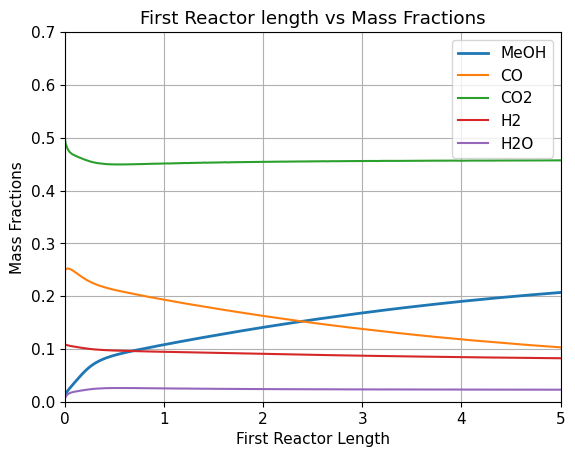

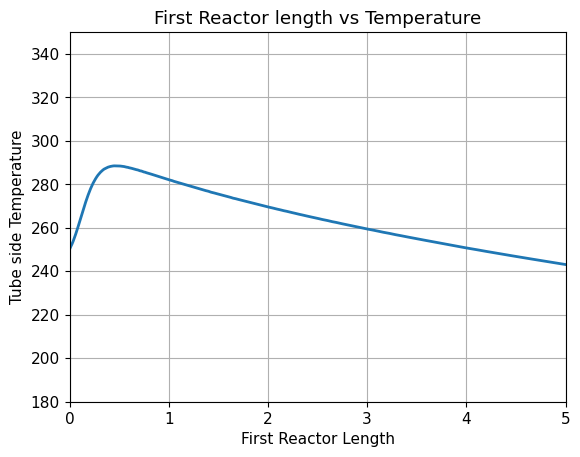

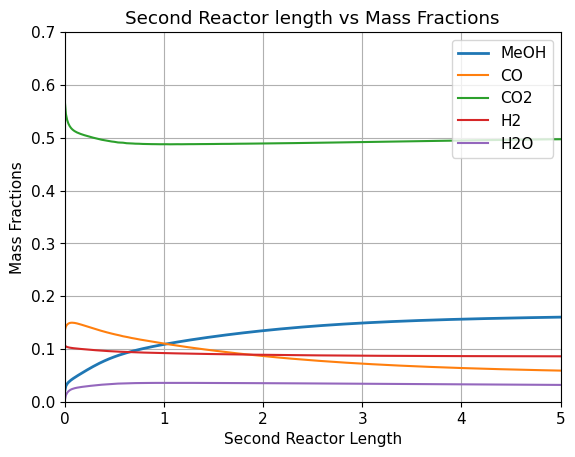

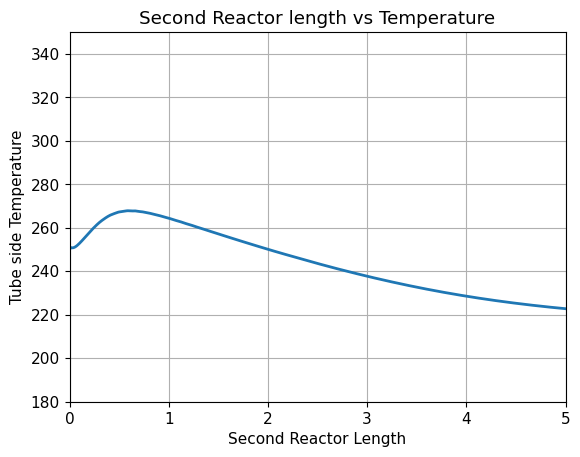

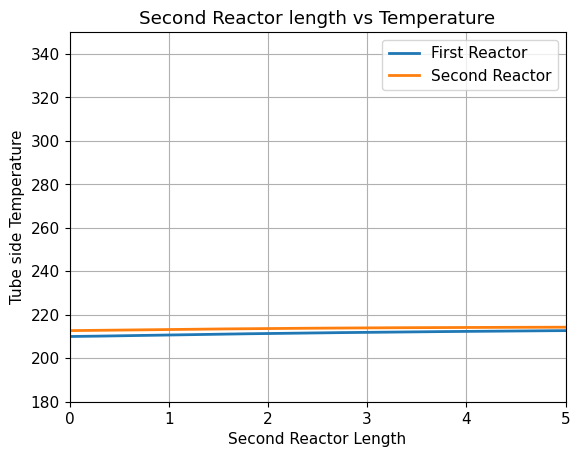

In [8]:
# Plotting

plt.figure(num=1)
plt.rc("font", size=11)
plt.plot(z,omega[0,:],'-',label='MeOH', linewidth=2.0)
plt.plot(z,omega[1,:],'-',label='CO')
plt.plot(z,omega[2,:],'-',label='CO2')
plt.plot(z,omega[3,:],'-',label='H2')
plt.plot(z,omega[4,:],'-',label='H2O')
plt.xlabel("First Reactor Length")
plt.ylabel("Mass Fractions")
plt.legend(loc=1)
plt.title("First Reactor length vs Mass Fractions")
plt.axis([0, L, 0, 0.7])
plt.grid()
plt.show()

plt.figure(num=2)
plt.rc("font", size=11)
plt.plot(z,T,'-', linewidth=2.0)
plt.xlabel("First Reactor Length")
plt.ylabel("Tube side Temperature")
plt.title("First Reactor length vs Temperature")
plt.axis([0, L, 180, 350])
plt.grid()
plt.show()

plt.figure(num=3)
plt.rc("font", size=11)
plt.plot(z,omega2[0,:],'-',label='MeOH', linewidth=2.0)
plt.plot(z,omega2[1,:],'-',label='CO')
plt.plot(z,omega2[2,:],'-',label='CO2')
plt.plot(z,omega2[3,:],'-',label='H2')
plt.plot(z,omega2[4,:],'-',label='H2O')
plt.xlabel("Second Reactor Length")
plt.ylabel("Mass Fractions")
plt.legend(loc=1)
plt.title("Second Reactor length vs Mass Fractions")
plt.axis([0, L, 0, 0.7])
plt.grid()
plt.show()

plt.figure(num=4)
plt.rc("font", size=11)
plt.plot(z,T2,'-', linewidth=2.0)
plt.xlabel("Second Reactor Length")
plt.ylabel("Tube side Temperature")
plt.title("Second Reactor length vs Temperature")
plt.axis([0, L, 180, 350])
plt.grid()
plt.show()

plt.figure(num=5)
plt.rc("font", size=11)
plt.plot(z,TShell,'-', label='First Reactor',linewidth=2.0)
plt.plot(z,TShell2,'-', label='Second Reactor', linewidth=2.0)
plt.xlabel("Second Reactor Length")
plt.ylabel("Tube side Temperature")
plt.title("Second Reactor length vs Temperature")
plt.axis([0, L, 180, 350])
plt.legend(loc=1)
plt.grid()
plt.show()
